In [4]:
# Importing all the libraries
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


## Loading the data

In [6]:
# Load data
train = pd.read_csv("train.csv")
print("Train data shape:", train.shape)
train.head()

Train data shape: (20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [7]:
test = pd.read_csv("test.csv")
print("Test data shape:", test.shape)
test.head()

Test data shape: (5200, 4)


,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [8]:
train["train/test"] = "train"
test["train/test"] = "test"

In [9]:
# Concatenate train and test data
combined_data = pd.concat([train, test], axis=0)
print("Combined data shape:", combined_data.shape)
combined_data.head()

Combined data shape: (26000, 6)


,id,title,author,text,label,train/test
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1.0,train
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0.0,train
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1.0,train
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1.0,train
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1.0,train


### Dropping Unnecessary Columns

In [10]:
combined_data = combined_data.drop(columns=["id", "author", "title", "label"], axis=1)
combined_data.head()

,text,train/test
0,House Dem Aide: We Didn’t Even See Comey’s Let...,train
1,Ever get the feeling your life circles the rou...,train
2,"Why the Truth Might Get You Fired October 29, ...",train
3,Videos 15 Civilians Killed In Single US Airstr...,train
4,Print \nAn Iranian woman has been sentenced to...,train


### Checking for null values and removing them

In [11]:
# Check for null values
combined_data.isnull().sum()

text          46
train/test     0
dtype: int64

In [12]:
# Replace missing values
combined_data = combined_data.fillna(" ")

### Cleaning the text and converting them to list of words

In [13]:
# Function to clean text
def clean(text):
    cleaned_text = re.sub("[^a-zA-Z]", " ", text)  # Remove non-alphabet characters
    cleaned_text = cleaned_text.lower()  # Convert to lower case
    return cleaned_text

# Apply the cleaning function
combined_data['cleaned_text'] = combined_data['text'].apply(lambda x : clean(x))
combined_data.head()

,text,train/test,cleaned_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,train,house dem aide we didn t even see comey s let...
1,Ever get the feeling your life circles the rou...,train,ever get the feeling your life circles the rou...
2,"Why the Truth Might Get You Fired October 29, ...",train,why the truth might get you fired october ...
3,Videos 15 Civilians Killed In Single US Airstr...,train,videos civilians killed in single us airstr...
4,Print \nAn Iranian woman has been sentenced to...,train,print an iranian woman has been sentenced to ...


In [14]:
# Function to convert text to list of words
def text_to_words(text):
    words = text.split()
    return words

# Apply the function to convert text to list of words
combined_data["text_to_words"] = combined_data["cleaned_text"].apply(text_to_words)
combined_data.head()

,text,train/test,cleaned_text,text_to_words
0,House Dem Aide: We Didn’t Even See Comey’s Let...,train,house dem aide we didn t even see comey s let...,"[house, dem, aide, we, didn, t, even, see, com..."
1,Ever get the feeling your life circles the rou...,train,ever get the feeling your life circles the rou...,"[ever, get, the, feeling, your, life, circles,..."
2,"Why the Truth Might Get You Fired October 29, ...",train,why the truth might get you fired october ...,"[why, the, truth, might, get, you, fired, octo..."
3,Videos 15 Civilians Killed In Single US Airstr...,train,videos civilians killed in single us airstr...,"[videos, civilians, killed, in, single, us, ai..."
4,Print \nAn Iranian woman has been sentenced to...,train,print an iranian woman has been sentenced to ...,"[print, an, iranian, woman, has, been, sentenc..."


## Stemming Data

In [15]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

# Apply the transformation
combined_data["cleaned_words"] = combined_data["text_to_words"].apply(
    lambda word_list: " ".join(
        [stemmer.stem(word) for word in word_list if word not in stop_words]
    )
)

In [16]:
combined_data.head(7)

,text,train/test,cleaned_text,text_to_words,cleaned_words
0,House Dem Aide: We Didn’t Even See Comey’s Let...,train,house dem aide we didn t even see comey s let...,"[house, dem, aide, we, didn, t, even, see, com...",hous dem aid even see comey letter jason chaff...
1,Ever get the feeling your life circles the rou...,train,ever get the feeling your life circles the rou...,"[ever, get, the, feeling, your, life, circles,...",ever get feel life circl roundabout rather hea...
2,"Why the Truth Might Get You Fired October 29, ...",train,why the truth might get you fired october ...,"[why, the, truth, might, get, you, fired, octo...",truth might get fire octob tension intellig an...
3,Videos 15 Civilians Killed In Single US Airstr...,train,videos civilians killed in single us airstr...,"[videos, civilians, killed, in, single, us, ai...",video civilian kill singl us airstrik identifi...
4,Print \nAn Iranian woman has been sentenced to...,train,print an iranian woman has been sentenced to ...,"[print, an, iranian, woman, has, been, sentenc...",print iranian woman sentenc six year prison ir...
5,"In these trying times, Jackie Mason is the Voi...",train,in these trying times jackie mason is the voi...,"[in, these, trying, times, jackie, mason, is, ...",tri time jacki mason voic reason week exclus c...
6,Ever wonder how Britain’s most iconic pop pian...,train,ever wonder how britain s most iconic pop pian...,"[ever, wonder, how, britain, s, most, iconic, ...",ever wonder britain icon pop pianist get long ...


In [17]:
# Function to count words
def word_count(text):
    text = str(text)
    return len(text.split(' '))

# Apply the word count function
combined_data['word_count'] = combined_data['cleaned_words'].apply(word_count)
combined_data.head()

,text,train/test,cleaned_text,text_to_words,cleaned_words,word_count
0,House Dem Aide: We Didn’t Even See Comey’s Let...,train,house dem aide we didn t even see comey s let...,"[house, dem, aide, we, didn, t, even, see, com...",hous dem aid even see comey letter jason chaff...,433
1,Ever get the feeling your life circles the rou...,train,ever get the feeling your life circles the rou...,"[ever, get, the, feeling, your, life, circles,...",ever get feel life circl roundabout rather hea...,367
2,"Why the Truth Might Get You Fired October 29, ...",train,why the truth might get you fired october ...,"[why, the, truth, might, get, you, fired, octo...",truth might get fire octob tension intellig an...,692
3,Videos 15 Civilians Killed In Single US Airstr...,train,videos civilians killed in single us airstr...,"[videos, civilians, killed, in, single, us, ai...",video civilian kill singl us airstrik identifi...,305
4,Print \nAn Iranian woman has been sentenced to...,train,print an iranian woman has been sentenced to ...,"[print, an, iranian, woman, has, been, sentenc...",print iranian woman sentenc six year prison ir...,86


In [18]:
# Display the text before and after preprocessing
print("Text Before Preprocessing:\n", combined_data["text"][0])
print("\nText After Preprocessing:\n", combined_data["cleaned_words"][0])

Text Before Preprocessing:
 0    House Dem Aide: We Didn’t Even See Comey’s Let...
0    PALO ALTO, Calif.  —   After years of scorning...
Name: text, dtype: object

Text After Preprocessing:
 0    hous dem aid even see comey letter jason chaff...
0    palo alto calif year scorn polit process silic...
Name: cleaned_words, dtype: object


## Splitting the data into training and testing data

In [19]:
# Split the combined data back into train and test sets
train_data = combined_data[combined_data["train/test"] == "train"]
test_data = combined_data[combined_data["train/test"] == "test"]

## Using one hot encoding and padding the encoded sequence

In [20]:
# One-hot encoding
vocab_size = 10000

# One-hot encode train data
train_words_list = train_data["cleaned_words"].tolist()
encoded_train = [one_hot(words, vocab_size) for words in train_words_list]

# One-hot encode test data
test_words_list = test_data["cleaned_words"].tolist()
encoded_test = [one_hot(words, vocab_size) for words in test_words_list]

In [21]:
# Padding sequences
text_length = 500

# Pad the encoded train data
padded_train = pad_sequences(encoded_train, padding="pre", maxlen=text_length)

# Pad the encoded test data
padded_test = pad_sequences(encoded_test, padding="pre", maxlen=text_length)

## Designing the LSTM model

In [22]:
# number of features is required to be mentioned in order to convert word into it's vector form 
embedding_features= 30

model= Sequential()
# this layer converts padded data into vectors
model.add(Embedding(vocab_size, embedding_features, input_length= text_length))
model.add(Dropout(0.3))

# LSTM layer with 50 neurons
model.add(LSTM(units= 50))
model.add(Dropout(0.3))

# output layer
model.add(Dense(units=1, activation="sigmoid"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Assuming you have the labels for the train data in a column named "label"
y = train['label']

In [24]:
# Splitting the train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_train, y, test_size=0.2, random_state=42)

## Fitting the model

In [26]:
model.compile(loss= "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history= model.fit(X_train, y_train,
          validation_data= (X_val, y_val),
          batch_size= 128, epochs=10)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 38s 255ms/step - accuracy: 0.9882 - loss: 0.0355 - val_accuracy: 0.9353 - val_loss: 0.2464
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 250ms/step - accuracy: 0.9955 - loss: 0.0176 - val_accuracy: 0.9298 - val_loss: 0.2710
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 34s 263ms/step - accuracy: 0.9966 - loss: 0.0152 - val_accuracy: 0.9337 - val_loss: 0.2845
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 33s 255ms/step - accuracy: 0.9980 - loss: 0.0098 - val_accuracy: 0.9334 - val_loss: 0.2892
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 248ms/step - accuracy: 0.9972 - loss: 0.0113 - val_accuracy: 0.9310 - val_loss: 0.2871
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 33s 253ms/step - accuracy: 0.9933 - loss: 0.0235 - val_accuracy: 0.9356 - val_loss: 0.3142
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 248ms/step - accuracy: 0.9687 - loss: 0.0861 - val_accuracy: 0.9163 - val_loss: 0.3060
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - accuracy: 0.9936 - loss: 0

In [27]:
# Predicting on the validation set
y_pred = (model.predict(X_val) > 0.5).astype("int32")

130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step


## Predicting on the test data

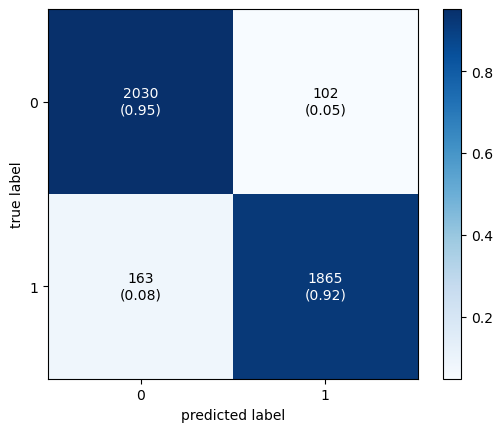

In [28]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

In [29]:
model.save('fakenewsmodel.h5')

In [30]:
test = """ Guillermo Barros Schelotto was not the first Argentine player to set foot on a Major League Soccer field. Statistically speaking, he was the 28th when he made his debut for the Columbus Crew in 2007. But Schelottoâ€™s phone still rings to this day, more than six years after he left the league, with calls from fellow Argentines looking for advice. Though Schelotto, 43, is currently the coach of Boca Juniors, the most decorated team in Argentina, most of the players who call him want to talk about other teams, about other countries, about a soccer world away from the   environment of Buenos Aires. â€œMost of them like to talk about the cities,â€ Schelotto said. Many of them find a way to come. Argentines now make up the   demographic in M. L. S. trailing only Americans. According to the Elias Sports Bureau, going into this seasonâ€™s openers, 98 Argentine players had been featured in an M. L. S.   game since the leagueâ€™s inception. Sebastian Blanco, a new designated player for Portland, made his debut in an opener Friday and became No. 99. In a ranking by nationality, Argentines have the   goal total, too. Twelve of the 22 teams in M. L. S. will start the season with at least one Argentine on their roster, a list that includes stars like Dallasâ€™s Mauro Diaz and Montrealâ€™s Ignacio Piatti and newcomers like Atlantaâ€™s Hector Villalba and New York City F. C.â€™s Maxi Moralez. Why do they come? For some itâ€™s the money, or at least the promise that it will be paid regularly. Others come for the lifestyle, the chance to fade into a comparative anonymity unavailable to them at home, or to live the â€œquiet, cleanâ€ life that Schelotto describes as he reminisces about his days in Ohio. The Portland Timbers playmaker Diego Valeri was one such player who called Schelotto, his former manager, and he eventually heeded his advice. But he said it was for an entirely different reason. A year before he signed with Portland, while under contract to his hometown club Lanus, Valeri had had a gun pressed to his throat when robbers attempted to steal his BMW with his wife, Florencia, and daughter, Connie, inside. â€œAfter that moment,â€ Valeri said with considerable understatement, â€œwe thought about opportunities to play outside and know different places in the world. â€ Within a year, Valeri, who had had loan spells in Portugal and Spain, was on his way to Portland. â€œSituations like that are very hard for the Argentinian people to change,â€ he said. The    Valeri and his family are now settled in the Northwest, where he is playing arguably the best soccer of his career. He is a     and in between was named the most valuable player when Portland won the 2015 M. L. S. Cup championship game. â€œI think they like the anonymity and the tranquillity here,â€ Caleb Porter, Valeriâ€™s coach with the Timbers, said of his star and his countrymen. â€œThey really relish the opportunity to be here and to live a lifestyle thatâ€™s different to how they lived in Argentina. They transition well into M. L. S. â€ Since 2011, Portland has signed six Argentines, including its   acquisition of Blanco, 28. Valeri has been a good ambassador  â€”   he speaks English and urges newcomers to try to learn it as soon as possible, to ease the transition. But Porter and the Timbersâ€™ general manager and president of soccer, Gavin Wilkinson, believe there is another, more straightforward reason for Argentinaâ€™s outsize presence in M. L. S.: It simply produces the kind of technical player that the league desires. â€œCertain countries produce certain positions more,â€ Porter said. â€œMost teams are looking for that creative piece, and you know you can get one in Argentina. â€ A large alumni directory and strong ties to agents and consultants in the region have made that kind of shopping easier for M. L. S. teams, and in the past the struggles of the Argentine economy also favored North American clubs, some said. But there also has been a change in the kind of individual looking to make the move north, and that has dovetailed with the leagueâ€™s overall transfer policy. As the quality of M. L. S. has improved as it enters its third decade, its teams have looked less for marketability from its imports  â€”   which in the past had trended toward aging, often European stars  â€”   and more toward onfield impact and value. The latest class of Argentines reflects this shift, as they enter a league where the average age of designated players  â€”   the teamâ€™s   stars  â€”   has fallen below 28, its lowest point in a decade. â€œThey know that M. L. S. is different to 10 years ago,â€ said Schelotto, who was 34 when he moved to the league. â€œThey can go, make good money, play with some pressure. They know they can make a career in the United States and then maybe move to Europe. â€œTen years ago, it was impossible. Right now, you can. â€ There are currently 24 Argentines playing in the league. Atlanta United and its Argentine coach, Tata Martino, brought in three ahead of its first season, each of them 25 or younger (Villalba is just 22). Buying young is now seen as more of a benefit to clubs than a risk, as players who continue to develop retain a   value if they move on to brighter prospects in Europe. â€œPeople are coming here younger and younger, maybe to start their careers,â€ Ignacio Piatti, a    playmaker for the Montreal Impact, said through an interpreter. â€œItâ€™s what they are looking for at that age: being able to live a comfortable life off the field and focus on their games. â€ Piatti, like Schelotto, has been happy to offer advice to the next wave of Argentine talents considering entering M. L. S. including players on both sides of the Hudson River. Gonzalo Veron, 27, of the Red Bulls, and Moralez, 30, who recently signed with New York City F. C. both acknowledged that they had turned to Piatti for advice before signing. At a community event in East Harlem last week, Moralez  â€”   who spent four years in Italy  â€”   reflected on his decision to move to the United States. He had never been to New York City before signing, he said, and after turning to the likes of Piatti and David Villa for advice about the leagueâ€™s standard of play, he said he also sought assurances for his family, who are set to join him in New York shortly. â€œFirst off, I just want to enjoy football,â€ Moralez said. â€œBut also to get to know the beauty of the city and the country. Not everybody gets the opportunity to come here. â€"""

In [31]:
corpus_test = []
review = re.sub('[^a-zA-Z]', ' ',test)
review = review.lower()
review = review.split()

review = [stemmer.stem(word) for word in review if not word in stopwords.words('english')]
review = ' '.join(review)
corpus_test.append(review)

In [32]:
onehot_repr_test = [one_hot(words,vocab_size)for words in corpus_test] 

In [33]:
sent_length = 25

embedded_docs_test = pad_sequences(onehot_repr_test,padding='pre',maxlen=sent_length)
print(embedded_docs_test)

[[3908  816 5188  101 5266 5567 6527 4245 7905 7994 1517 7791 7909  250
  4145 3908 4703 9777 1753 1489 9904  880 4703  302 4173]]


In [34]:
X_test = np.array(embedded_docs_test)

In [35]:
check = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


In [36]:
check

array([[0.0192807]], dtype=float32)

In [37]:
if check <= 0.6:
    print("Real News")
else:
    print("Fake News")

Real News
